In [1]:
import pandas as pd
import numpy as np
import re 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px
import datetime
from matplotlib.pyplot import *
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import utils
import multiprocessing
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from transformers import AlbertTokenizer, AlbertModel
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from etl import *

In [28]:
df = format_data('politifact_data.csv')
df['Tokens'] = df['Quote'].apply(lambda x: nltk.word_tokenize(x))
# df = df[~df.Label.str.contains("remove")]
df = df.sample(frac=1)
df.head()

,Quote,Source,Date,Post Author,Link,Label,Year,Tokens
14052,foreign company united state significantly hi...,Sherrod Brown,"April 25, 2011",Tom Feran,https://www.politifact.com/factchecks/2011/apr...,true,2011,"[foreign, company, united, state, significantl..."
15255,john boehner called repealing rest stimulus w...,Austan Goolsbee,"September 13, 2010",Robert Farley,https://www.politifact.com/factchecks/2010/sep...,false,2010,"[john, boehner, called, repealing, rest, stimu..."
10204,american want traditional marriage defined de...,Bill Johnson,"July 10, 2013",Stephen Koff,https://www.politifact.com/factchecks/2013/jul...,false,2013,"[american, want, traditional, marriage, define..."
13182,stimulus created zero job,National Republican Senatorial Committee,"October 21, 2011",Warren Fiske,https://www.politifact.com/factchecks/2011/oct...,false,2011,"[stimulus, created, zero, job]"
9657,history united state 168 presidential nominee...,Harry Reid,"November 22, 2013",Louis Jacobson,https://www.politifact.com/factchecks/2013/nov...,true,2013,"[history, united, state, 168, presidential, no..."


In [3]:
df.groupby('Label').count()

,Quote,Source,Date,Post Author,Link,Year,Tokens
Label,,,,,,,
false,8508,8508,8508,8508,8508,8508,8508
true,8201,8201,8201,8201,8201,8201,8201


## Create Train and Test Sets

In [29]:
df_train = df[-int(len(df)*.8):]
df_test = df[int(len(df)*.8):]
df_test.head()

,Quote,Source,Date,Post Author,Link,Label,Year,Tokens
12426,say traffic fatality fallen dramatically even...,Sam Adams,"March 9, 2012",Ian K. Kullgren,https://www.politifact.com/factchecks/2012/mar...,true,2012,"[say, traffic, fatality, fallen, dramatically,..."
9490,job involve minimum wage overwhelmingly job y...,Scott Walker,"January 13, 2014",Dave Umhoefer,https://www.politifact.com/factchecks/2014/jan...,false,2014,"[job, involve, minimum, wage, overwhelmingly, ..."
11838,oregon school receive million dollar per year...,Ron Wyden,"June 29, 2012",Charles Pope,https://www.politifact.com/factchecks/2012/jun...,true,2012,"[oregon, school, receive, million, dollar, per..."
15229,harry reid voted give special tax break illeg...,Sharron Angle,"September 17, 2010",Louis Jacobson,https://www.politifact.com/factchecks/2010/sep...,false,2010,"[harry, reid, voted, give, special, tax, break..."
2797,canadian face major donut shortage first day ...,worldnewsdailyreport.com,"October 25, 2018",Kyra Haas,https://www.politifact.com/factchecks/2018/oct...,false,2018,"[canadian, face, major, donut, shortage, first..."


In [30]:
train_tagged = df_train.apply(lambda r: TaggedDocument(words=r['Tokens'], tags=r['Label']), axis=1)
test_tagged = df_test.apply(lambda r: TaggedDocument(words=r['Tokens'], tags=r['Label']), axis=1)

In [31]:
cores = multiprocessing.cpu_count()

In [32]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 13367/13367 [00:00<00:00, 2277224.27it/s]


In [33]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 13367/13367 [00:00<00:00, 1137572.52it/s]


In [34]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [35]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5927588270496709
Testing F1 score: 0.5926118400926518


In [36]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 13367/13367 [00:00<00:00, 1223117.53it/s]


In [37]:
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 13367/13367 [00:00<00:00, 1485920.37it/s]


In [38]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Testing accuracy 0.7187312986235787
Testing F1 score: 0.7187104430979424


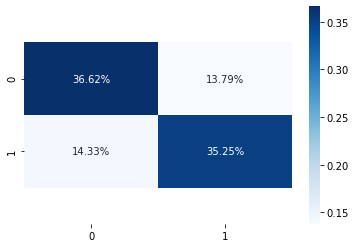

In [43]:
labels = ['false', 'true']
cf_matrix = confusion_matrix(y_test, y_pred, labels)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show() 


In [30]:
df_test.groupby('Label').count()

,Quote,Source,Date,Post Author,Link,Year,Tokens
Label,,,,,,,
false,1720,1720,1720,1720,1720,1720,1720
true,1622,1622,1622,1622,1622,1622,1622


In [40]:
# Create CBOW model 
model1 = gensim.models.Doc2Vec(df_train['Tokens'], min_count = 1, size = 300, window = 5) 

model2 = gensim.models.Doc2Vec(df_train['Tokens'], min_count = 1, size = 300, 
                                             window = 5, sg = 1) 

AttributeError: 'list' object has no attribute 'words'

In [32]:
# Print results 
print("Cosine similarity between 'trump' " +
          "and 'facebook' - CBOW Gram : ", 
    model1.similarity('trump', 'facebook')) 
      
print("Cosine similarity between 'trump' " +
            "and 'facebook' - Skip Gram : ", 
      model2.similarity('trump', 'facebook')) 

Cosine similarity between 'trump' and 'facebook' - CBOW Gram :  0.90871054
Cosine similarity between 'trump' and 'facebook' - Skip Gram :  0.71090585


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [36]:
model1.wv['trump']

array([ 0.30365828, -0.13708614, -0.2978775 , -0.05190181,  0.08627668,
        0.23044613, -0.3718273 ,  0.4843164 ,  0.16885597,  0.5094671 ,
        0.22226027,  0.33733374,  0.30097088,  0.02182713,  0.07912996,
       -0.4947738 ,  0.3995816 ,  0.13739586,  0.33007812, -0.05742243,
       -0.47576   , -0.28904766, -0.35722652, -0.4248053 , -0.03551352,
       -0.01741863,  0.57888156,  0.25720105, -0.2671308 , -0.42264146,
       -0.3533567 ,  0.46793547, -0.893341  , -0.04854772, -0.7033893 ,
       -0.82646567,  0.24596739, -0.6107101 ,  0.25935763, -0.03448507,
        0.07813197, -0.09595884, -1.0127698 , -0.638655  , -1.0723855 ,
        0.70451736,  0.61105055,  0.66271955,  0.517212  ,  0.25973734,
        0.7878838 , -0.73284537,  0.04226067,  0.48667702,  0.20541129,
       -0.07256269, -0.5981365 ,  0.39681685,  0.08420083,  0.10966729,
       -0.2888665 ,  0.31220788, -0.48453742,  0.07837938, -0.0934082 ,
        0.5775672 ,  0.1575059 ,  0.40698555, -0.18017048,  0.22

In [ ]:
for i, word in enumerate(model1.wv.vocab):
    if i == 100:
        break
    print(word)

In [63]:
#https://www.kdnuggets.com/2018/11/multi-class-text-classification-doc2vec-logistic-regression.html
doc.words

NameError: name 'doc' is not defined

In [81]:
type(train_tagged.values[0])

gensim.models.doc2vec.TaggedDocument

In [4]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [5]:
tokenized = df['Quote'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [6]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
np.array(padded).shape

In [71]:
X_train = df_train['ALBERT Tokens']
y_train = df_train['Label']

X_test = df_test['ALBERT Tokens']
y_test = df_test['Label']

In [76]:
from transformers import AlbertTokenizer, AlbertModel
import torch
import tensorflow as tf

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained('albert-base-v2')

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**X_train)
learning_rate = 2e-5
# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1
# model initialization
# classifier Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# last_hidden_states = outputs[0]

AttributeError: 'AlbertModel' object has no attribute 'compile'

In [51]:
outputs

(tensor([[[ 1.3997,  1.5700,  0.3336,  ..., -0.0686,  0.2804,  0.8287],
          [ 0.3306,  0.3647,  0.7145,  ..., -0.5266,  1.2512, -0.7155],
          [ 1.1538,  0.6781, -1.6579,  ...,  0.6821,  0.3878,  0.4889],
          ...,
          [ 1.5001, -0.4411,  1.2422,  ...,  1.3102,  0.0211, -1.0564],
          [ 0.4044, -0.0901,  1.0914,  ...,  0.4799,  0.6582, -1.0785],
          [ 0.0455,  0.1439, -0.0616,  ..., -0.0906,  0.1141,  0.2033]]],
        grad_fn=<NativeLayerNormBackward>),
 tensor([[ 0.4210, -0.5434,  0.7271, -0.9191,  0.6473, -0.9005,  0.5429, -0.4988,
           0.5720, -0.9995,  0.9408,  0.4471, -0.1917, -0.9711, -0.9631, -0.4996,
           0.4965,  0.5118,  0.9865, -0.5392, -0.8583, -0.9906,  0.9915,  0.9829,
           0.7456, -0.5302,  0.6063, -0.9586, -0.9997, -0.5337, -1.0000,  0.5163,
           0.5575,  0.5369,  0.5593, -0.4074,  0.5447,  0.9906, -0.5874,  0.5187,
           0.5323, -0.9912, -0.8540,  0.4816,  0.5048,  0.5025,  0.9911, -0.9777,
           0.69

In [5]:
pip install transformers --user

Note: you may need to restart the kernel to use updated packages.
